【問題1】ラグランジュの未定乗数法による最急降下

In [3]:
# 最大化する関数(勾配降下の逆)
def _gradient_descent(X, y, lag, lr=0.1):
    """
    傾きを計算する。
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
    訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
    目的データ
    lag : 次の形のndarray, shape(n_samples, 1)
    ラグランジュ乗数
    lr : float
    学習率
    Returns
    -------
    次の形のndarray, shape (n_samples, 1)
    更新後のtheta
    """
    
    sigma = (lag * y * X).sum(axis=0)
    lag = lag + lr * (1 - ((y * X) @ sigma).reshape((X.shape[0], 1)))
    
    for i in range(lag.shape[0]):
        if lag[i] < 0:
            lag[i] = 0
        
                 
    # sigma = 1 * n_features
    # y * X = n_sample * n_futures
    
    return lag

【問題2】サポートベクターの決定

In [5]:
def get_SV(lag, C=1e-5):
    """
    サポートベクターの数及びサポートベクターを取得する
    parameters
    ----------------------
    lag : 次の形のndarray, shape(n_samples, 1)
    ラグランジュ乗数
    C : float
    サポートベクターの閾値
    
    returns
    ----------------------
    count_sv : int
    サポートベクターの数
    SV_list : list
    サポートベクターのリスト
    """
    
    
    SV_list = []
    count_sv = (lag > C).sum()
    for i in range(lag.shape[0]):
        if lag[i] > C:
            SV_list.append(X[i])
            
    return count_sv, SV_list

【問題3】推定<br>
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた f ( x ) の符号が分類結果です。

【問題4】学習と推定

In [7]:

import numpy as np

class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.SV_X_ndarray : 次の形のndarray, shape(n_samples, n_feature)
     サポートベクターの特徴量
    self.SV_y_ndarray : 次の形のndarray, shape(n_samples, 1)
     サポートベクターのラベル
    self.SV_　lag_ndarray : 次の形のndarray, shape(n_samples, 1)
     サポートベクターのラグランジュ乗数
    """
    
    
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
        
        # 最大化する関数(勾配降下の逆)
    def _gradient_descent(self, X, y, lag):
        """
        ラグランジュ関数の最大化を行う
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        y : 次の形のndarray, shape (n_samples, 1)
        目的データ
        lag : 次の形のndarray, shape(n_samples, 1)
        ラグランジュ乗数
        lr : float
        学習率
        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        更新後のラグランジュ関数
        """
        
        sigma = (lag * y * X).sum(axis=0)
        lag = lag + self.lr * (1 - ((y * X) @ sigma).reshape((X.shape[0], 1)))
        
        for i in range(lag.shape[0]):
            if lag[i] < 0:
                lag[i] = 0
        # sigma = 1 * n_features
        # y * X = n_sample * n_futures

        return lag

    
    def get_SV(self, X, y, lag):
        """
        サポートベクターの数及びサポートベクターを取得する
        parameters
        ----------------------
        lag : 次の形のndarray, shape(n_samples, 1)
        ラグランジュ乗数
        C : float
        サポートベクターの閾値

        returns
        ----------------------
        SV_X_ndarray : 次の形のndarray, shape(n_samples, n_feature)
        サポートベクターの特徴量
        SV_y_ndarray : 次の形のndarray, shape(n_samples, 1)
        サポートベクターのラベル
        SV_　lag_ndarray : 次の形のndarray, shape(n_samples, 1)
        サポートベクターのラグランジュ乗数
        """
        index_list = []
        count = 0
        # 閾値より高いラグランジュ乗数の個数
        count_sv = (lag > self.threshold).sum()
        
        SV_X_ndarray = np.zeros((count_sv, X.shape[1]))
        SV_y_ndarray = np.zeros((count_sv, 1))
        SV_lag_ndarray = np.zeros((count_sv, 1))
        
        for i in range(lag.shape[0]):
            
            if lag[i] > self.threshold:
                
                # index番号を保存
                index_list.append(i)
                
                # 閾値より高いサポートベクターのパラメータを保存
                SV_X_ndarray[count] = X[i]
                SV_y_ndarray[count] = y[i]
                SV_lag_ndarray[count] = lag[i]
                count += 1

        # 使わないのでインスタンス化
        self.n_support_vectors = count_sv
        self.index_support_vectors  = index_list
        
        return SV_X_ndarray, SV_y_ndarray, SV_lag_ndarray
        
  
    def fit(self, X, y):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        
        # 初期値の設定
        lag = np.zeros((X.shape[0], 1))
        lag_history = np.zeros((self.iter, X.shape[0]))
        
        # yの設定
        y = y.reshape((y.shape[0], 1))
        
        # 学習
        for n in range(self.iter):
            lag = self._gradient_descent(X, y, lag)
            lag_history[n] = lag.T
            
        # SVの決定
        self.SV_X_ndarray, self.SV_y_ndarray, self.SV_lag_ndarray = self.get_SV(X, y, lag)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(lag_history)
        
        
    def predict(self, test_X):
        """
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
    
        f = np.zeros((test_X.shape[0], 1))

        # テストデータ分推定の実行
        for n in range(test_X.shape[0]):
            f[n] = (self.SV_y_ndarray * self.SV_lag_ndarray * (self.SV_X_ndarray @ test_X[n:n+1].T)).sum()

            if f[n] > 0:
                f[n] = 1
            else:
                f[n] = -1

        return f

データの読み込み

In [8]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

In [9]:
from sklearn.preprocessing import StandardScaler
sclear = StandardScaler()
X = sclear.fit_transform(X)

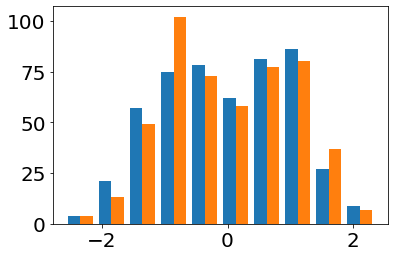

In [10]:
import matplotlib.pyplot as plt
plt.hist(X);

In [11]:
from sklearn.model_selection import train_test_split
X_75, X_25 = train_test_split(X, random_state=0)
y_75, y_25 = train_test_split(y, random_state=0)

公式モデルでの実行

In [12]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', random_state=0)
svc.fit(X_75, y_75)
svc_pred = svc.predict(X_25)

from sklearn.metrics import classification_report
print(classification_report(y_25, svc_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def decision_region(X, y, model, step=0.01, title='decision region', xlabel='x1', ylabel='x2', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    a = np.min(X[:,0])-0.5 # Sepallabelの最小値-0.5
    b = np.max(X[:,0])+0.5 # Sepallabelの最大値+0.5
    c = np.min(X[:,1])-0.5 # Petallabelの最小値-0.5
    d = np.max(X[:,1])+0.5 # Petallabelの最小値+0.5
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(a, b, step), np.arange(c, d, step))
    
    e = np.ravel(mesh_f0) #列が全部指定したもの
    f = np.ravel(mesh_f1) #行が全部指定したもの
    
    mesh = np.c_[e,f] # グラフ領域(2次元)に左上から00.01-といった形で数字をつけた
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color)) # 等高線の間の色付
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)# 等高線の描画
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o') # 散布図の作成
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)] # よくわからんけど凡例の書き方を入れてる
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

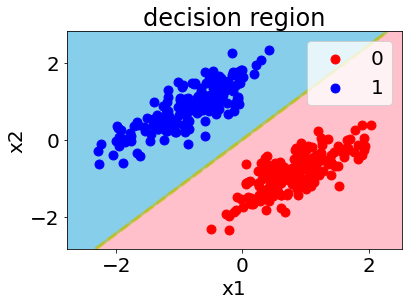

In [14]:
decision_region(X_75, y_75, svc)

自作モデルでの実行

In [20]:
my_svc = ScratchSVMClassifier(num_iter=100, lr=0.008)
my_svc.fit(X_75, y_75)

In [21]:
my_svc.n_support_vectors

8

In [22]:
print(classification_report(y_25, my_svc.predict(X_25)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



【問題5】決定領域の可視化

In [23]:
def decision_region_2(X, y, SV_index_list, model, step=0.01, title='decision region', xlabel='x1', ylabel='x2', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    a = np.min(X[:,0])-0.5 # Sepallabelの最小値-0.5
    b = np.max(X[:,0])+0.5 # Sepallabelの最大値+0.5
    c = np.min(X[:,1])-0.5 # Petallabelの最小値-0.5
    d = np.max(X[:,1])+0.5 # Petallabelの最小値+0.5
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(a, b, step), np.arange(c, d, step))
    
    e = np.ravel(mesh_f0) #列が全部指定したもの
    f = np.ravel(mesh_f1) #行が全部指定したもの
    
    mesh = np.c_[e,f] # グラフ領域(2次元)に左上から00.01-といった形で数字をつけた
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color)) # 等高線の間の色付
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)# 等高線の描画
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o') # 散布図の作成
    for i in (SV_index_list):
        plt.scatter(X[i, 0], X[i, 1], color='g', s=100)
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)] # よくわからんけど凡例の書き方を入れてる
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [24]:
my_svc.index_support_vectors

[27, 44, 60, 181, 192, 278, 290, 363]

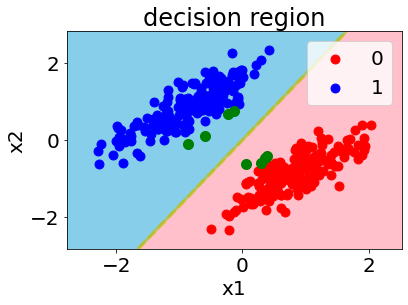

In [25]:
decision_region_2(X_75, y_75, my_svc.index_support_vectors, my_svc)